In [1]:
import pandas as pd
import numpy as np

In [2]:
cols = ['customer', 'accepted', 'reward', 'mailer', 'income', 'accounts', 'overdraft_protection', 'credit_rating', 'cards', 'homes', 'household', 'own_home', 'bal_q1', 'bal_q2', 'bal_q3', 'bal_q4', 'bal_avg']

data = pd.read_csv('data/creditcardmarketing.csv', names = cols)

data = data.drop('customer', axis = 1)
data

,accepted,reward,mailer,income,accounts,overdraft_protection,credit_rating,cards,homes,household,own_home,bal_q1,bal_q2,bal_q3,bal_q4,bal_avg
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,167.50,136.0,65.0,71.0,398.0
17996,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850.50,984.0,940.0,943.0,535.0
17997,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087.25,918.0,767.0,1170.0,1494.0
17998,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,1022.25,626.0,983.0,865.0,1615.0


In [3]:
data.isna().sum()

accepted                 0
reward                   0
mailer                   0
income                   0
accounts                 0
overdraft_protection     0
credit_rating            0
cards                    0
homes                    0
household                0
own_home                 0
bal_q1                  24
bal_q2                  24
bal_q3                  24
bal_q4                  24
bal_avg                 24
dtype: int64

In [4]:
# removing small bins in 'household' and NA in balances 

data = data[data['bal_q1'].isna() == False]
data = data[data['household'] < 8]
data = data.reset_index(drop=True)
# HH = 8 
# HH = 9
# NA in balance

In [5]:
data.shape

(17974, 16)

In [6]:
# incoding the classes

data['accepted'] = np.where(data['accepted'].isin(['Yes']), 1, 0)
data['accepted'].value_counts()

0    16954
1     1020
Name: accepted, dtype: int64

In [7]:
## some charts with share of Yes vs media and reward program

In [8]:

high = data[(data['mailer']=='Postcard')&(data['reward']=='Air Miles')]

low  = data[~((data['mailer']=='Postcard')&(data['reward']=='Air Miles'))&(data['accepted']==1)]

data1 = pd.concat([high,low], axis = 0)

data = data1

In [9]:
obj_cols = ['income', 'accounts', 'credit_rating', 'cards', 'homes', 'own_home', 'household']
num_cols = ['bal_avg']
 
# 'reward', 'mailer', - dropped as not related to customers, not an independent variable
# 'overdraft_protection', - dropped due to same variance if grouped by acceptance
# 'bal_q1', 'bal_q2', 'bal_q3', 'bal_q4', - same variance if grouped by acceptance


data_cat = data[obj_cols]
data_num = data[num_cols]
data_num = data_num.reset_index(drop=True)

In [10]:
# encoding categoricals

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first') # The option drop='first' drops one of the possible values.
encoder.fit(data_cat)
data_cat_encoded = encoder.transform(data_cat).toarray() # "np.sparse_array"!!
cols = encoder.get_feature_names_out(input_features=data_cat.columns)
data_cat_df = pd.DataFrame(data_cat_encoded, columns=cols)


### Balanced random forest

In [11]:
X_full = pd.concat([data_cat_df,data_num], axis = 1)
y_full = data['accepted']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.20)

from sklearn.preprocessing import StandardScaler

transformer = StandardScaler()
transformer.fit(X_train) 
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)


In [12]:
# random forest but balanced for class imbalance

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate

clf = BalancedRandomForestClassifier(criterion = 'gini', min_samples_split =4, min_samples_leaf=2, class_weight = {0:0.5,1:1},replacement=True)
clf.fit(X_train, y_train)

print("The accuracy for the Random Forest in the TRAIN  set is {:.2f}".format(clf.score(X_train, y_train)))

y_train_pred = clf.predict(X_train)
display(pd.DataFrame(y_train_pred).value_counts())
display(y_train.value_counts())
display(confusion_matrix(y_train, y_train_pred))

print("The accuracy for the Random Forest in the TEST  set is {:.2f}".format(clf.score(X_test, y_test)))

y_test_pred = clf.predict(X_test)
display(pd.DataFrame(y_test_pred).value_counts())
display(y_test.value_counts())
display(confusion_matrix(y_test, y_test_pred))


results = cross_validate(clf,X_full, y_full, cv = 5) 
print('The results of cross-validation (full dataset):',(results['test_score']).mean())

# it gives low accuracy, however it correctly identifies all class 1 entries('accepted') 

The accuracy for the Random Forest in the TRAIN  set is 0.65


1    1858
0    1178
dtype: int64

0    2218
1     818
Name: accepted, dtype: int64

array([[1165, 1053],
       [  13,  805]])

The accuracy for the Random Forest in the TEST  set is 0.50


1    505
0    254
dtype: int64

0    557
1    202
Name: accepted, dtype: int64

array([[214, 343],
       [ 40, 162]])

The results of cross-validation (full dataset): 0.5454545454545455


In [13]:
data_filtered = data[(data['credit_rating'].isin(['High','Medium']))&
                     (data['household']>3)&
                     (data['cards']<3)&
                     (data['own_home']=='Yes')]

data_cat_f = data_filtered[obj_cols]
data_num_f = data_filtered[num_cols].reset_index(drop=True)

data_cat_encoded_f = encoder.transform(data_cat_f).toarray() 
cols = encoder.get_feature_names_out(input_features=data_cat_f.columns)
data_cat_f_df = pd.DataFrame(data_cat_encoded_f, columns=cols)

X_full_f = pd.concat([data_cat_f_df,data_num_f], axis = 1)
y_full_f = data_filtered['accepted']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_full_f, y_full_f, test_size=0.20,random_state=42)

transformer = StandardScaler()
transformer.fit(X_train) 
X_train_f = transformer.transform(X_train_f)
X_test_f  = transformer.transform(X_test_f)


print("The accuracy for the Random Forest in the TEST  set is {:.2f}".format(clf.score(X_test_f, y_test_f)))
y_test_pred_f = clf.predict(X_test_f)
print('Predicted outcomes')
display(pd.DataFrame(y_test_pred_f).value_counts())
print('Actual outcomes')
display(y_test_f.value_counts())
display(confusion_matrix(y_test_f, y_test_pred_f))


The accuracy for the Random Forest in the TEST  set is 0.72
Predicted outcomes


/Users/ttrofff/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/ttrofff/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


0    83
1    34
dtype: int64

Actual outcomes


0    98
1    19
Name: accepted, dtype: int64

array([[74, 24],
       [ 9, 10]])

### Neural Net

In [14]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

early_stopping = EarlyStopping(patience=5) 

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

model_c1 = keras.Sequential()

model_c1.add(Dense(units = 16,input_dim = X_train.shape[1],activation='relu')) 

model_c1.add(Dense(units = 16, activation='relu')) 

model_c1.add(Dense(units = 8, activation='relu'))

model_c1.add(Dense(units = 8, activation='relu'))

model_c1.add(Dense(units = 1, activation='sigmoid')) # output

model_c1.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
              )

model_c1.summary()

checkpoint_path = 'models/cls-nn1.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_weights_only=False,
    verbose=1
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                304       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 793
Trainable params: 793
Non-trainable params: 0
_________________________________________________________________


2022-06-28 18:48:37.820324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X_train, y_train)

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_tl), y = y_tl)
class_weights_dict = dict(enumerate(class_weights))


from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto',k_neighbors=5)
X_sm, y_sm = smote.fit_resample(X_tl, y_tl)


In [16]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_tl, y_tl)

In [17]:
class_weights_dict_man = {0: 1, 1: 2}
class_weights_dict

{0: 0.7161733615221987, 1: 1.656479217603912}

In [18]:


history_c1 = model_c1.fit(
    X_sm, 
    y_sm, 
    epochs=50, 
    validation_split=0.20, 
    batch_size=50, 
    verbose=1,
    callbacks=[early_stopping,checkpoint],
    class_weight = class_weights_dict_man,
    #class_weight = class_weights_dict
    
)

Epoch 1/50
58/61 [===========================>..] - ETA: 0s - loss: 0.9476 - accuracy: 0.4631
Epoch 1: saving model to models/cls-nn1.hdf5
61/61 [==============================] - 1s 8ms/step - loss: 0.9467 - accuracy: 0.4675 - val_loss: 0.6534 - val_accuracy: 0.7266
Epoch 2/50
60/61 [============================>.] - ETA: 0s - loss: 0.9176 - accuracy: 0.5607
Epoch 2: saving model to models/cls-nn1.hdf5
61/61 [==============================] - 0s 4ms/step - loss: 0.9183 - accuracy: 0.5616 - val_loss: 0.5938 - val_accuracy: 0.8203
Epoch 3/50
51/61 [========================>.....] - ETA: 0s - loss: 0.8885 - accuracy: 0.5941
Epoch 3: saving model to models/cls-nn1.hdf5
61/61 [==============================] - 0s 5ms/step - loss: 0.8921 - accuracy: 0.5946 - val_loss: 0.6070 - val_accuracy: 0.7543
Epoch 4/50
51/61 [========================>.....] - ETA: 0s - loss: 0.8716 - accuracy: 0.6294
Epoch 4: saving model to models/cls-nn1.hdf5
61/61 [==============================] - 0s 5ms/step - lo

In [19]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 

    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

y_pred_train = model_c1.predict(X_train).round(0) ## rounded to 1
y_pred_test  = model_c1.predict(X_test).round(0) ## rounded to 1

y_train1 = np.array(y_train).reshape(-1,1)
y_test1  = np.array(y_test).reshape(-1,1)

results = model_performance_class(y_train1, y_pred_train, y_test1, y_pred_test)
results

display(confusion_matrix(y_test1, y_pred_test))



24/24 [==============================] - 0s 2ms/step
Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.31
              precision    recall  f1-score   support

           0       0.89      0.60      0.71      2218
           1       0.42      0.80      0.55       818

    accuracy                           0.65      3036
   macro avg       0.66      0.70      0.63      3036
weighted avg       0.77      0.65      0.67      3036

Results obtained for the TEST SET
The Cohen's Kappa is: 0.16
              precision    recall  f1-score   support

           0       0.83      0.51      0.63       557
           1       0.34      0.71      0.46       202

    accuracy                           0.56       759
   macro avg       0.59      0.61      0.55       759
weighted avg       0.70      0.56      0.59       759



array([[285, 272],
       [ 59, 143]])

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(n_estimators = 500, max_depth=6, min_samples_split =2, min_samples_leaf=1)
GBC.fit(X_train, y_train)


print("The accuracy for the GBC in the TRAIN  set is {:.2f}".format(GBC.score(X_train, y_train)))

y_train_pred = GBC.predict(X_train)
display(pd.DataFrame(y_train_pred).value_counts())
display(y_train.value_counts())
display(confusion_matrix(y_train, y_train_pred))

print("The accuracy for the GBC in the TEST  set is {:.2f}".format(GBC.score(X_test, y_test)))

y_test_pred = GBC.predict(X_test)
display(pd.DataFrame(y_test_pred).value_counts())
display(y_test.value_counts())
display(confusion_matrix(y_test, y_test_pred))


results = cross_validate(clf,X_full, y_full, cv = 5) 
print('The results of cross-validation (full dataset):',(results['test_score']).mean())

The accuracy for the GBC in the TRAIN  set is 1.00


0    2220
1     816
dtype: int64

0    2218
1     818
Name: accepted, dtype: int64

array([[2217,    1],
       [   3,  815]])

The accuracy for the GBC in the TEST  set is 0.68


0    609
1    150
dtype: int64

0    557
1    202
Name: accepted, dtype: int64

array([[463,  94],
       [146,  56]])

The results of cross-validation (full dataset): 0.5454545454545455


In [21]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

print("The accuracy for the GNB in the TRAIN  set is {:.2f}".format(gnb.score(X_train, y_train)))

y_train_pred = gnb.predict(X_train)
display(pd.DataFrame(y_train_pred).value_counts())
display(y_train.value_counts())
display(confusion_matrix(y_train, y_train_pred))

print("The accuracy for the GNB in the TEST  set is {:.2f}".format(gnb.score(X_test, y_test)))

y_test_pred = gnb.predict(X_test)
display(pd.DataFrame(y_test_pred).value_counts())
display(y_test.value_counts())
display(confusion_matrix(y_test, y_test_pred))

results = cross_validate(clf,X_full, y_full, cv = 5) 
print('The results of cross-validation (full dataset):',(results['test_score']).mean())

The accuracy for the GNB in the TRAIN  set is 0.70


0    2274
1     762
dtype: int64

0    2218
1     818
Name: accepted, dtype: int64

array([[1796,  422],
       [ 478,  340]])

The accuracy for the GNB in the TEST  set is 0.70


0    560
1    199
dtype: int64

0    557
1    202
Name: accepted, dtype: int64

array([[445, 112],
       [115,  87]])

The results of cross-validation (full dataset): 0.5496706192358366


### TSNE

In [22]:
X_cool = X_full#.drop(['reward_Cash Back', 'reward_Points','mailer_Postcard'],axis=1)
X_cool = pd.concat([X_cool,y_full.reset_index(drop=True)],axis=1)
cols = X_cool.columns
from sklearn.preprocessing import MinMaxScaler

transformer = StandardScaler()
transformer.fit(X_cool) 
X_cool = transformer.transform(X_cool)


In [23]:
from sklearn.manifold import TSNE
X_embedded = TSNE (n_components = 2, learning_rate = 'auto', init = 'random').fit_transform(X_cool)
#X_embedded.shape

In [24]:
xx = [row[0] for row in X_embedded]
yy = [row[1] for row in X_embedded]

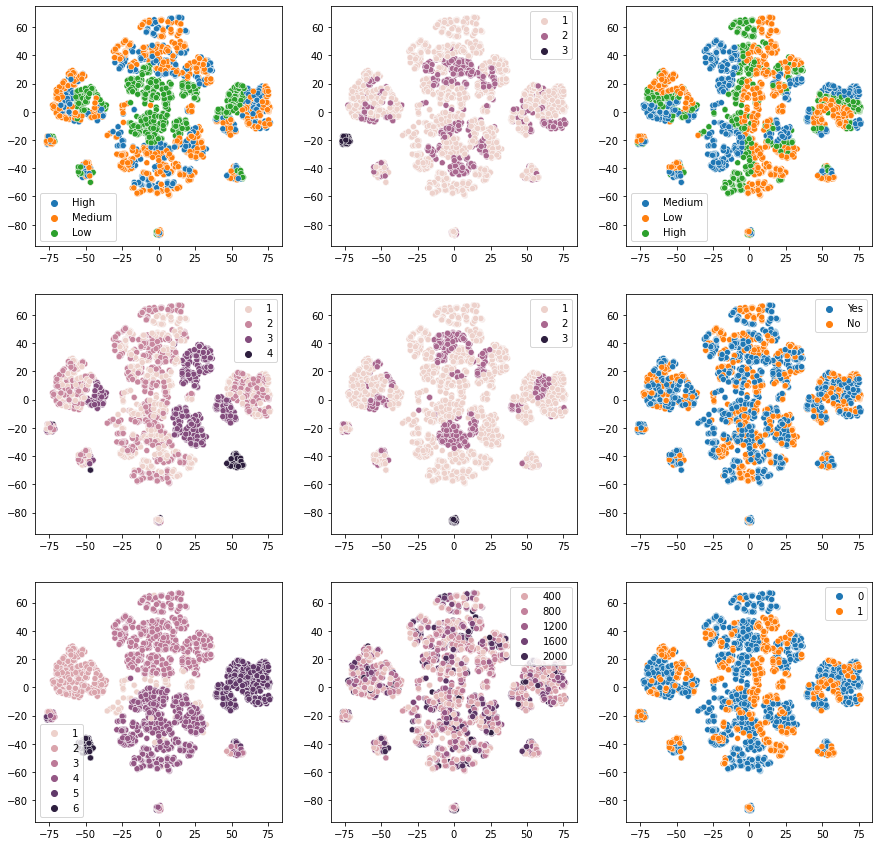

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns 
import math
%matplotlib inline

cols = obj_cols+num_cols
cols.extend(['accepted'])

fig, ax1 = plt.subplots(math.ceil(len(cols)/3),3, figsize=(15,15)) 
for n,col in enumerate(cols):
    sns.scatterplot( x=xx, y = yy, hue=[i for i in data[col]], ax=ax1[math.floor(n/3),n%3])
    

In [26]:
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=30, random_state=42, verbose=1)
X_full=X_full[X_full.columns]
kmeans.fit(X_full)
clusters = kmeans.predict(X_full)
#clusters
pd.Series(clusters).value_counts().sort_index() 

Initialization complete
Iteration 0, inertia 1912757.0.
Iteration 1, inertia 1656722.0397101329.
Iteration 2, inertia 1614474.785754144.
Iteration 3, inertia 1593802.8615246038.
Iteration 4, inertia 1582496.2525824185.
Iteration 5, inertia 1574323.700883984.
Iteration 6, inertia 1569348.7980957087.
Iteration 7, inertia 1566343.1078137257.
Iteration 8, inertia 1562460.1397984372.
Iteration 9, inertia 1558186.3100754882.
Iteration 10, inertia 1555181.135701877.
Iteration 11, inertia 1553186.2454895983.
Iteration 12, inertia 1552784.0567434472.
Converged at iteration 12: center shift 1.0685440214897213 within tolerance 1.696835837449558.
Initialization complete
Iteration 0, inertia 1857232.0.
Iteration 1, inertia 1628046.694853631.
Iteration 2, inertia 1585326.8687578877.
Iteration 3, inertia 1565348.2965127937.
Iteration 4, inertia 1553518.458705843.
Iteration 5, inertia 1546610.752241284.
Iteration 6, inertia 1543631.7742420733.
Iteration 7, inertia 1542100.2695129542.
Iteration 8, iner

0     207
1     109
2     154
3      87
4     147
5     169
6     100
7     141
8      73
9     205
10     57
11     90
12     71
13    159
14    205
15    141
16     81
17    169
18     56
19    131
20    182
21    101
22    146
23     78
24    136
25    167
26     90
27    175
28     97
29     71
dtype: int64

In [28]:
data1['cluster'] = clusters

In [44]:
summary = data1[['cluster','accepted']].groupby(['cluster']).sum()
summary['total'] = data1[['cluster','accepted']].groupby(['cluster']).count()
summary['share'] = (summary['accepted']/summary['total']).round(2)
summary

,accepted,total,share
cluster,,,
0,64,207,0.31
1,25,109,0.23
2,41,154,0.27
3,18,87,0.21
4,42,147,0.29
5,40,169,0.24
6,23,100,0.23
7,46,141,0.33
8,21,73,0.29
